# Concrete introduction to working with data from the Picarro G2308 at UPM Dpto Química

_By Rasmus Einarsson_

We are currently (March 2022) developing a software tool to analyze data from a Picarro G2308, which is being used together with automatic chambers to measure fluxes of CO2, N2O, and CH4 fluxes from soils.

The purpose of this document is to demonstrate in a concrete way
* What do the data files from the Picarro G2308 contain, and how can they be read into Python?
* What are some of the pitfalls that need to be considered when analyzing the data?
* How are the gas fluxes calculated from the data?

In [53]:
from typing import List
import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import shutil


In [74]:
fig_outdir = Path("intro-figures")
if fig_outdir.exists():
    shutil.rmtree(fig_outdir)
fig_outdir.mkdir()

In [54]:
# Each file covers roughly one hour of data and
# is named after its date and start time.
data_dir = Path("../example_data/picarro-data-overview")
data_paths = sorted(data_dir.iterdir())
data_paths


[PosixPath('../example_data/picarro-data-overview/JFAADS2179-20210629-104128-DataLog_User.dat'),
 PosixPath('../example_data/picarro-data-overview/JFAADS2179-20210629-114137-DataLog_User.dat'),
 PosixPath('../example_data/picarro-data-overview/JFAADS2179-20210629-124148-DataLog_User.dat'),
 PosixPath('../example_data/picarro-data-overview/JFAADS2179-20210629-134158-DataLog_User.dat')]

# Read one data file

The `.dat` files are fixed-width text files, separated by whitespace.

There is a large number of columns, many of which we don't need at the moment. We will use
* `EPOCH_TIME` which is the [Unix timestamp](https://en.wikipedia.org/wiki/Unix_time), here expressed in seconds with three decimals (so millisecond resolution). Alternatively, the columns `DATE` and `TIME` etc could be used, but these are in local time which can cause a lot of trouble when passing from daylight saving time to normal time. All this is avoided by using the Unix timestamp which is always in UTC ([roughly](https://en.wikipedia.org/wiki/Unix_time#UTC_basis)).
* `solenoid_valves`, which is in this case the variable indicating which chamber we are currently sampling from.
* `N2O_dry`, `CH4_dry`, `CO2`, which are gas concentrations we are interested in here
* `ALARM_STATUS`, which equals 0 unless the system is warning for a problem.

In [55]:
def read_raw_data(path: Path) -> pd.DataFrame:
    return pd.read_csv(path, sep=r"\s+")


raw_data_sample = read_raw_data(data_paths[0])
raw_data_sample


,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,...,CH4_dry,H2O,NH3,ChemDetect,peak_1a,peak_41,peak_4,peak15,ch4_splinemax,nh3_conc_ave
0,2021-06-29,10:41:18.582,179.403687,4305.688495,180.403687,1.624956e+09,0,963,140.000226,44.999992,...,1.975799,2.000206,36.029912,0.0,0.664109,59.533997,2.770412,115.091599,419.460339,36.365217
1,2021-06-29,10:41:19.407,179.403697,4305.688724,180.403697,1.624956e+09,0,963,140.000226,44.999992,...,1.975622,2.001059,35.972241,0.0,0.664109,59.533997,2.770412,115.091599,419.460339,36.365217
2,2021-06-29,10:41:20.052,179.403704,4305.688903,180.403704,1.624956e+09,0,963,139.991364,45.000053,...,1.975483,2.001726,35.927039,0.0,0.664109,59.533997,2.770412,115.427159,419.460339,35.946553
3,2021-06-29,10:41:20.812,179.403713,4305.689115,180.403713,1.624956e+09,0,963,139.996963,45.000053,...,1.975249,1.999760,35.996307,0.0,0.664109,59.610708,2.770412,115.427159,419.460339,35.946553
4,2021-06-29,10:41:21.934,179.403726,4305.689426,180.403726,1.624956e+09,0,963,139.998215,45.000053,...,1.974903,1.996843,36.098431,0.0,0.783874,59.610708,2.320005,115.427159,419.460339,35.946553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,2021-06-29,11:41:24.789,179.445426,4306.690219,180.445426,1.624960e+09,0,963,140.002255,45.000294,...,16.343244,1.893371,5.949693,0.0,0.642798,58.930217,2.115015,108.990487,3479.342066,5.346850
3782,2021-06-29,11:41:25.401,179.445433,4306.690389,180.445433,1.624960e+09,0,963,139.998596,45.000237,...,16.336367,1.894364,6.028726,0.0,0.642798,58.930217,2.115015,109.550971,3479.342066,6.158085
3783,2021-06-29,11:41:26.197,179.445442,4306.690611,180.445442,1.624960e+09,0,963,140.001587,45.000237,...,16.327066,1.893899,6.087252,0.0,0.642798,59.228130,2.115015,109.550971,3479.342066,6.158085
3784,2021-06-29,11:41:27.391,179.445456,4306.690942,180.445456,1.624960e+09,0,963,139.998139,45.000237,...,16.313128,1.893215,6.174970,0.0,0.534233,59.228130,1.979059,109.550971,3479.342066,6.158085


In [56]:
columns_to_read = [
    "EPOCH_TIME",
    "solenoid_valves",
    "ALARM_STATUS",
    "N2O_dry",
    "CH4_dry",
    "CO2",
]
raw_data_sample[columns_to_read]


,EPOCH_TIME,solenoid_valves,ALARM_STATUS,N2O_dry,CH4_dry,CO2
0,1.624956e+09,6.0,0,0.323819,1.975799,455.484181
1,1.624956e+09,6.0,0,0.323834,1.975622,455.483843
2,1.624956e+09,6.0,0,0.341416,1.975483,431.831183
3,1.624956e+09,6.0,0,0.362116,1.975249,403.925463
4,1.624956e+09,6.0,0,0.392637,1.974903,362.781937
...,...,...,...,...,...,...
3781,1.624960e+09,3.0,0,0.316735,16.343244,389.546490
3782,1.624960e+09,3.0,0,0.303944,16.336367,396.371487
3783,1.624960e+09,3.0,0,0.287313,16.327066,405.233729
3784,1.624960e+09,3.0,0,0.262385,16.313128,418.515963


In [57]:
# The Unix timestamp can be converted to a more human-friendly format as follows:
def unix_timestamp_to_time(timestamps: pd.Series) -> pd.Series:
    return pd.to_datetime(
        timestamps.mul(1e3).round().astype(int),  # to integer number of milliseconds
        unit="ms",
    )


unix_timestamp_to_time(raw_data_sample["EPOCH_TIME"])


0      2021-06-29 08:41:18.582
1      2021-06-29 08:41:19.407
2      2021-06-29 08:41:20.052
3      2021-06-29 08:41:20.813
4      2021-06-29 08:41:21.935
                 ...          
3781   2021-06-29 09:41:24.789
3782   2021-06-29 09:41:25.402
3783   2021-06-29 09:41:26.198
3784   2021-06-29 09:41:27.391
3785   2021-06-29 09:41:28.230
Name: EPOCH_TIME, Length: 3786, dtype: datetime64[ns]

## Inspect the alarm data

In this case we find that the alarm status is always zero.
When analyzing real data it would be necessary to handle alarm data,
for example by throwing away all the samples with the alarm on.

In [58]:
raw_data_sample["ALARM_STATUS"].unique()


array([0])

## Inspect and clean the valve numbers

Here we find a small number of non-integer valve numbers.
Looking closely in the data (not shown here), it can be seen that these values appear
for one or two seconds when the machine is switching from one valve to the next.
These few non-integer values can be discarded.

In [59]:
raw_data_sample["solenoid_valves"].value_counts()


7.000000    1435
2.000000     923
3.000000     923
6.000000     501
6.888620       2
2.473684       1
2.777778       1
Name: solenoid_valves, dtype: int64

In [60]:
def clean_valve_numbers(data):
    valve_number = data["solenoid_valves"]
    valve_number_is_integer = valve_number.round() == valve_number
    return data[valve_number_is_integer].astype({"solenoid_valves": "int"})


clean_valve_numbers(raw_data_sample[columns_to_read])["solenoid_valves"].value_counts()


7    1435
2     923
3     923
6     501
Name: solenoid_valves, dtype: int64

In [61]:
## Combine the data cleaning operations
def clean_raw_data(data):
    data = data[columns_to_read]
    data.index = unix_timestamp_to_time(data["EPOCH_TIME"])
    data = data[data["ALARM_STATUS"] == 0]
    data = data.drop(columns=["EPOCH_TIME", "ALARM_STATUS"])
    data = clean_valve_numbers(data)
    return data


cleaned_data_example = clean_raw_data(raw_data_sample)
cleaned_data_example


,solenoid_valves,N2O_dry,CH4_dry,CO2
EPOCH_TIME,,,,
2021-06-29 08:41:18.582,6,0.323819,1.975799,455.484181
2021-06-29 08:41:19.407,6,0.323834,1.975622,455.483843
2021-06-29 08:41:20.052,6,0.341416,1.975483,431.831183
2021-06-29 08:41:20.813,6,0.362116,1.975249,403.925463
2021-06-29 08:41:21.935,6,0.392637,1.974903,362.781937
...,...,...,...,...
2021-06-29 09:41:24.789,3,0.316735,16.343244,389.546490
2021-06-29 09:41:25.402,3,0.303944,16.336367,396.371487
2021-06-29 09:41:26.198,3,0.287313,16.327066,405.233729


## Make a figure of the cleaned data

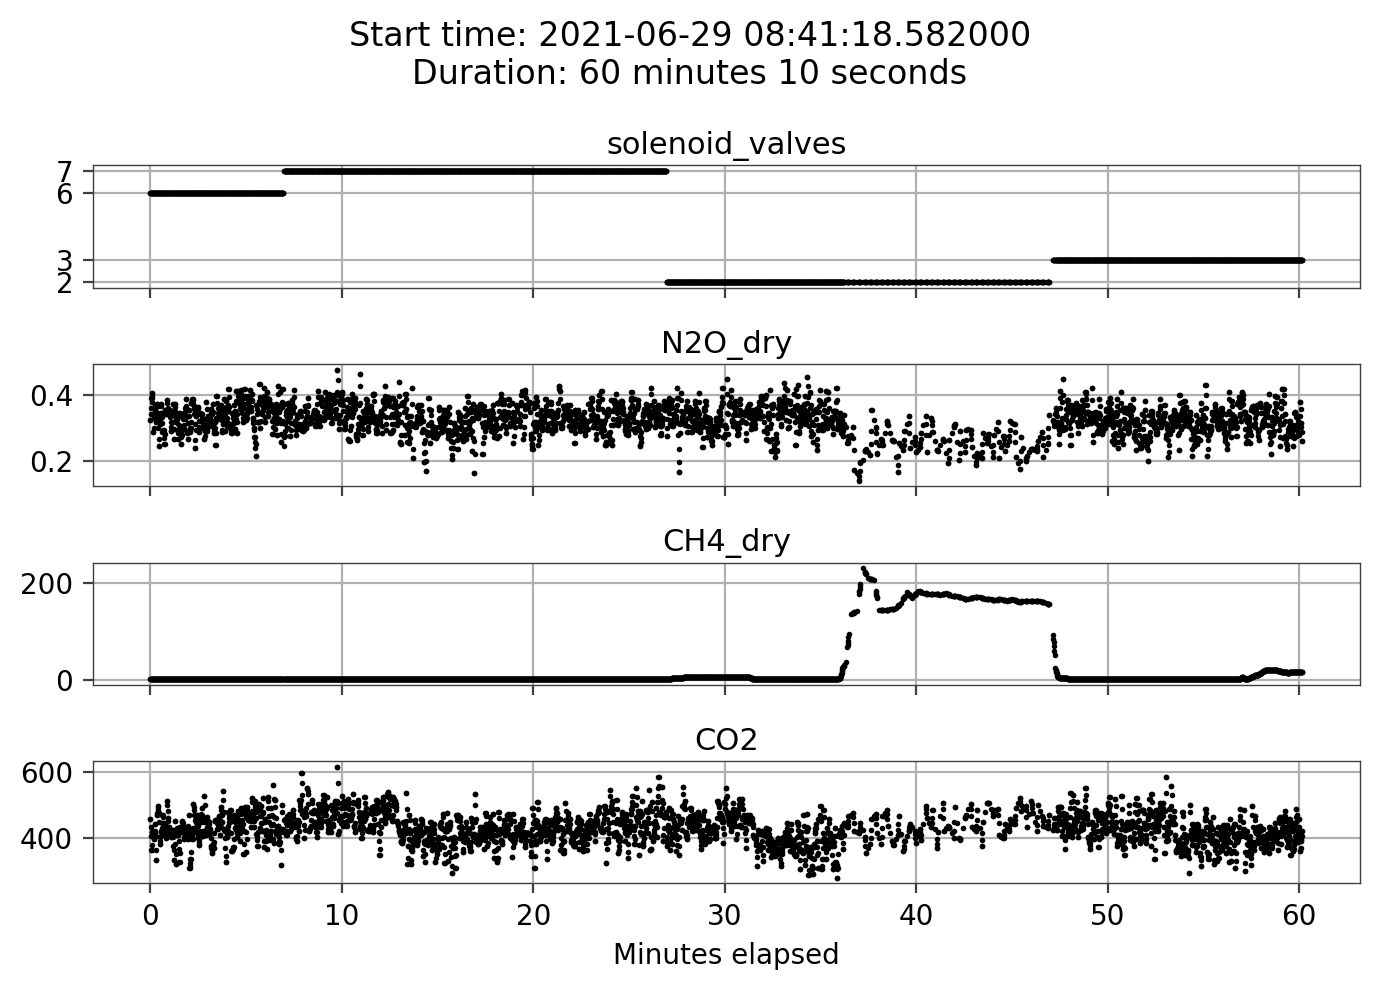

In [75]:
def plot_data(data: pd.DataFrame):
    minutes_elapsed = (data.index - data.index[0]).total_seconds() / 60
    fig, axs = plt.subplots(
        nrows=len(data.columns),
        sharex=True,
        figsize=(7, 5),
    )
    for column, ax in zip(data.columns, axs):
        ax.plot(
            minutes_elapsed,
            data[column],
            color="k",
            marker=".",
            ms=2,
            lw=0,
        )
        ax.set_title(column)

        ax.grid(True)

    axs[-1].set_xlabel("Minutes elapsed")
    axs[0].set_yticks(sorted(data["solenoid_valves"].unique()))

    duration = data.index[-1] - data.index[0]
    duration_total_seconds = duration.total_seconds()
    duration_minutes = int(duration_total_seconds / 60)
    duration_seconds = int(round(duration_total_seconds - duration_minutes * 60))
    fig.suptitle(
        f"Start time: {data.index[0]}\n"
        f"Duration: {duration_minutes} minutes {duration_seconds} seconds"
    )
    fig.set_tight_layout(True)

    return fig


fig = plot_data(cleaned_data_example)
fig.savefig(fig_outdir / "example-hour-file.png", dpi=200)


## Load and plot all the data from multiple files

In [63]:
raw_data_chunks = [read_raw_data(path) for path in data_paths]
cleaned_data_chunks = [clean_raw_data(raw_data) for raw_data in raw_data_chunks]
cleaned_all = pd.concat(cleaned_data_chunks)
cleaned_all


,solenoid_valves,N2O_dry,CH4_dry,CO2
EPOCH_TIME,,,,
2021-06-29 08:41:18.582,6,0.323819,1.975799,455.484181
2021-06-29 08:41:19.407,6,0.323834,1.975622,455.483843
2021-06-29 08:41:20.052,6,0.341416,1.975483,431.831183
2021-06-29 08:41:20.813,6,0.362116,1.975249,403.925463
2021-06-29 08:41:21.935,6,0.392637,1.974903,362.781937
...,...,...,...,...
2021-06-29 12:41:54.516,6,0.323828,1.976422,441.992794
2021-06-29 12:41:55.339,6,0.323847,1.976612,441.995879
2021-06-29 12:41:55.760,6,0.341602,1.976709,433.866101


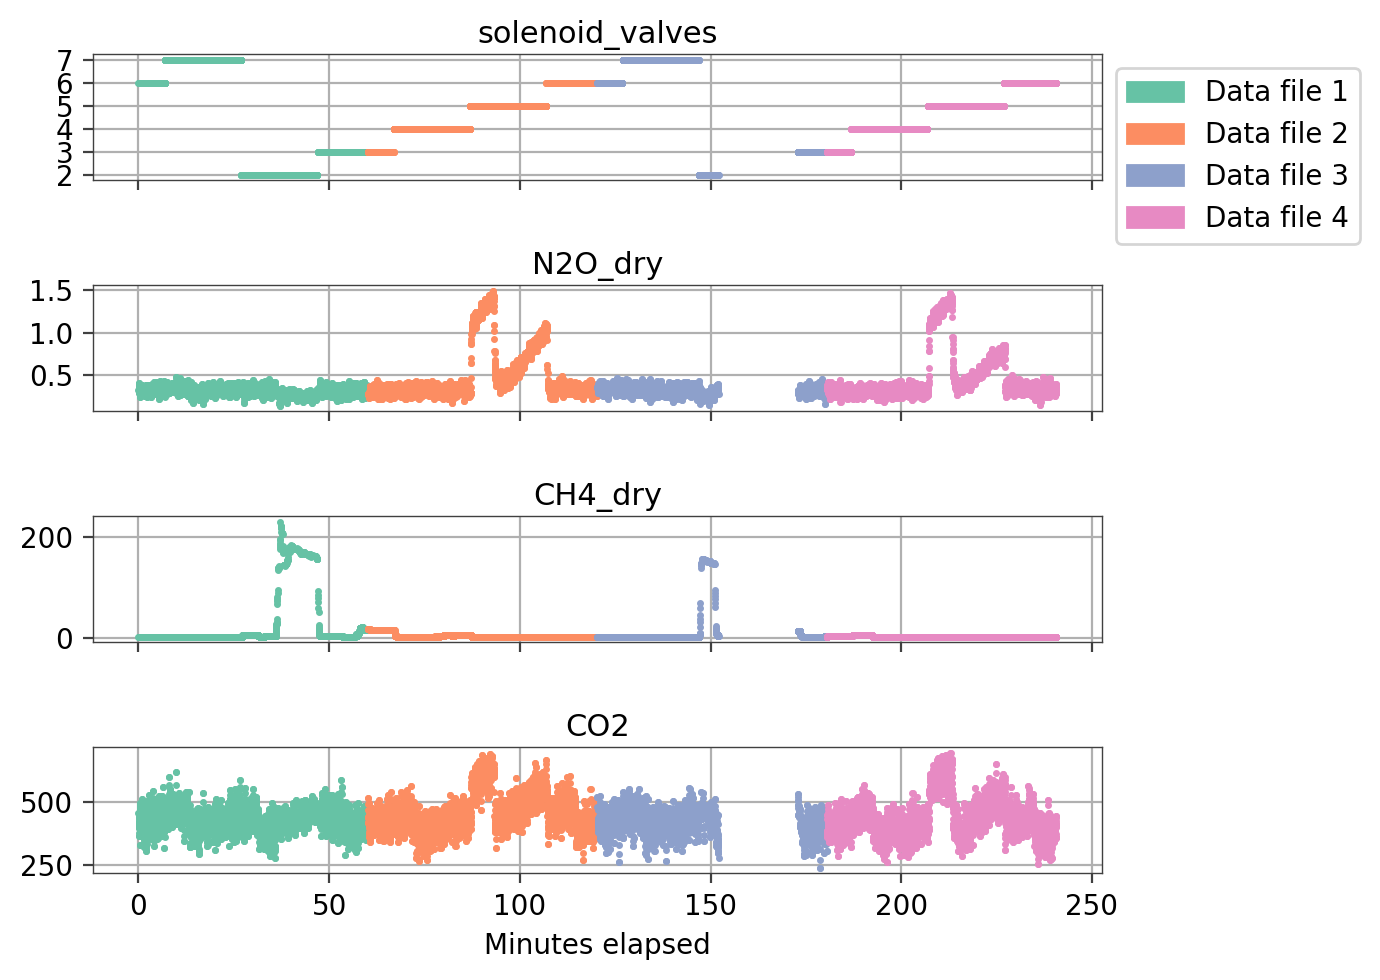

In [76]:
def plot_multiple_datasets(datasets: List[pd.DataFrame]):
    # Here assuming that all the datasets have the same columns
    columns = datasets[0].columns

    # Also assuming that the datasets are in chronological order
    start_time = datasets[0].index[0]

    fig, axs = plt.subplots(
        nrows=len(columns),
        sharex=True,
        figsize=(7, 5),
    )
    colors = plt.cm.get_cmap("Set2").colors
    for data, color in zip(datasets, colors):
        minutes_elapsed = (data.index - start_time).total_seconds() / 60

        for column, ax in zip(columns, axs):
            ax.plot(
                minutes_elapsed,
                data[column],
                color=color,
                marker=".",
                ms=3,
                lw=0,
            )
            ax.set_title(column)
            ax.grid(True)

        axs[0].legend(
            handles=[
                matplotlib.patches.Patch(color=color, label=f"Data file {i+1}")
                for i, (data, color) in enumerate(zip(datasets, colors))
            ],
            bbox_to_anchor=(1, 1),
        )

    axs[0].set_yticks(
        sorted(set.union(*(set(data["solenoid_valves"].unique()) for data in datasets)))
    )
    axs[-1].set_xlabel("Minutes elapsed")
    fig.set_tight_layout(True)

    return fig


fig = plot_multiple_datasets(cleaned_data_chunks)
fig.savefig(fig_outdir / "example-four-files.png", dpi=200)


Here it is now clear that the third dataset is missing some data. In this case it is an "error" manually created for demonstration purposes, but when analyzing real data we should expect such data to appear, e.g., if there is a problem with the equipment or when we are starting up or shutting down.

## Divide the data into segments using the valve number

Each such segment is a "measurement" in the sense that the data will be analyzed as one unit to make one gas flux estimate.

But note that some of the "measurements" are not complete. Here, they should be 20 minutes, but at the start and end of the dataset and in connection to the missing data segment in the middle of file 3, some of the measurements now are not the full 20 minutes. In the data analysis, it is therefore important to handle any measurements with the "wrong" duration. The simplest solution is to discard the whole measurement.

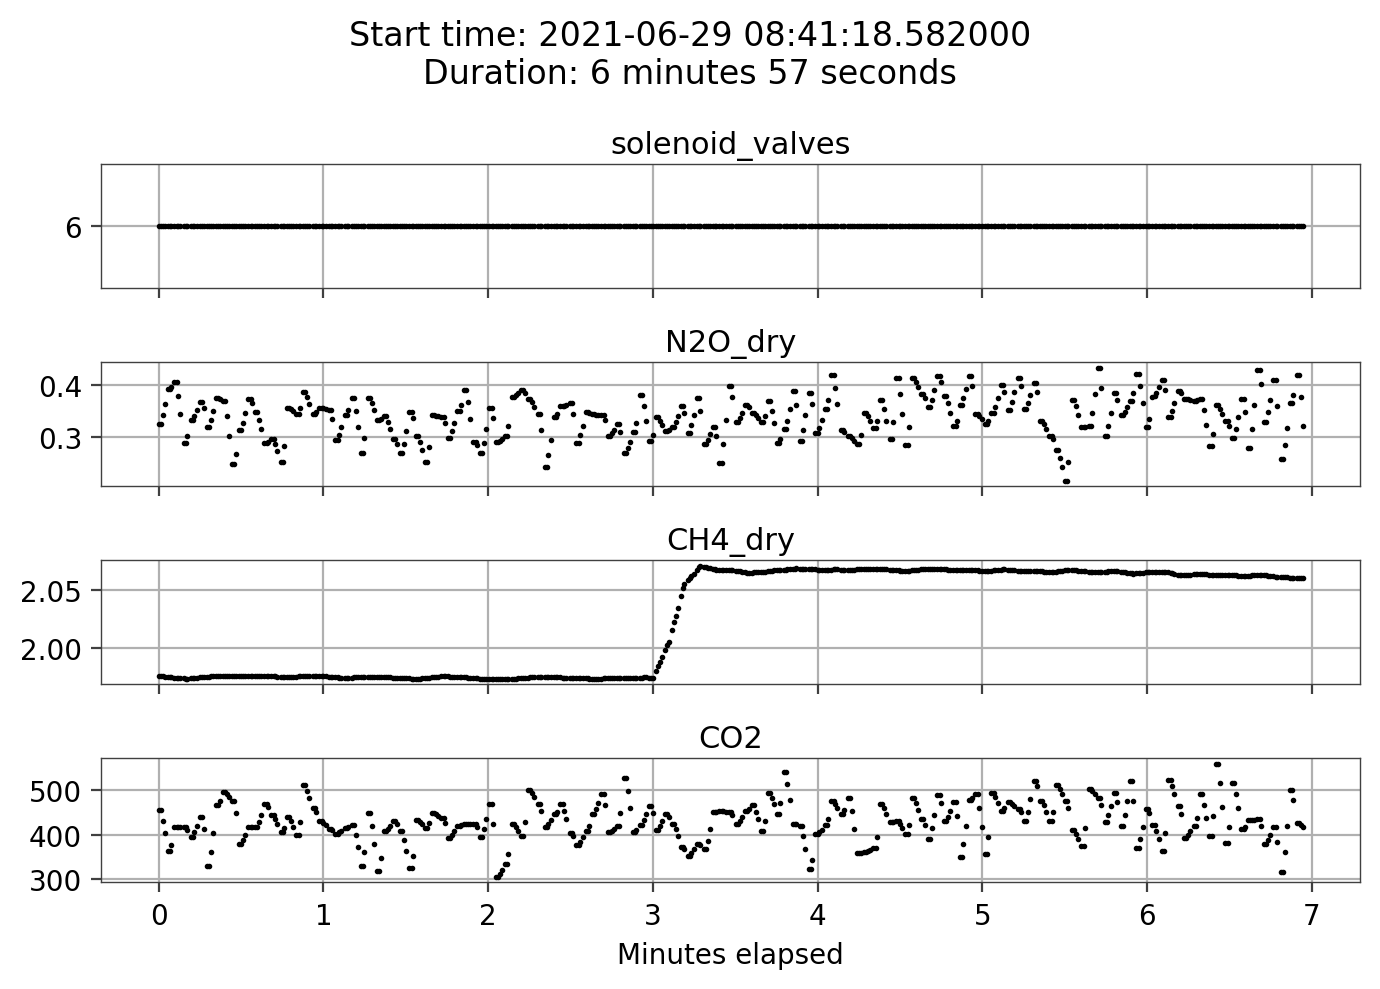

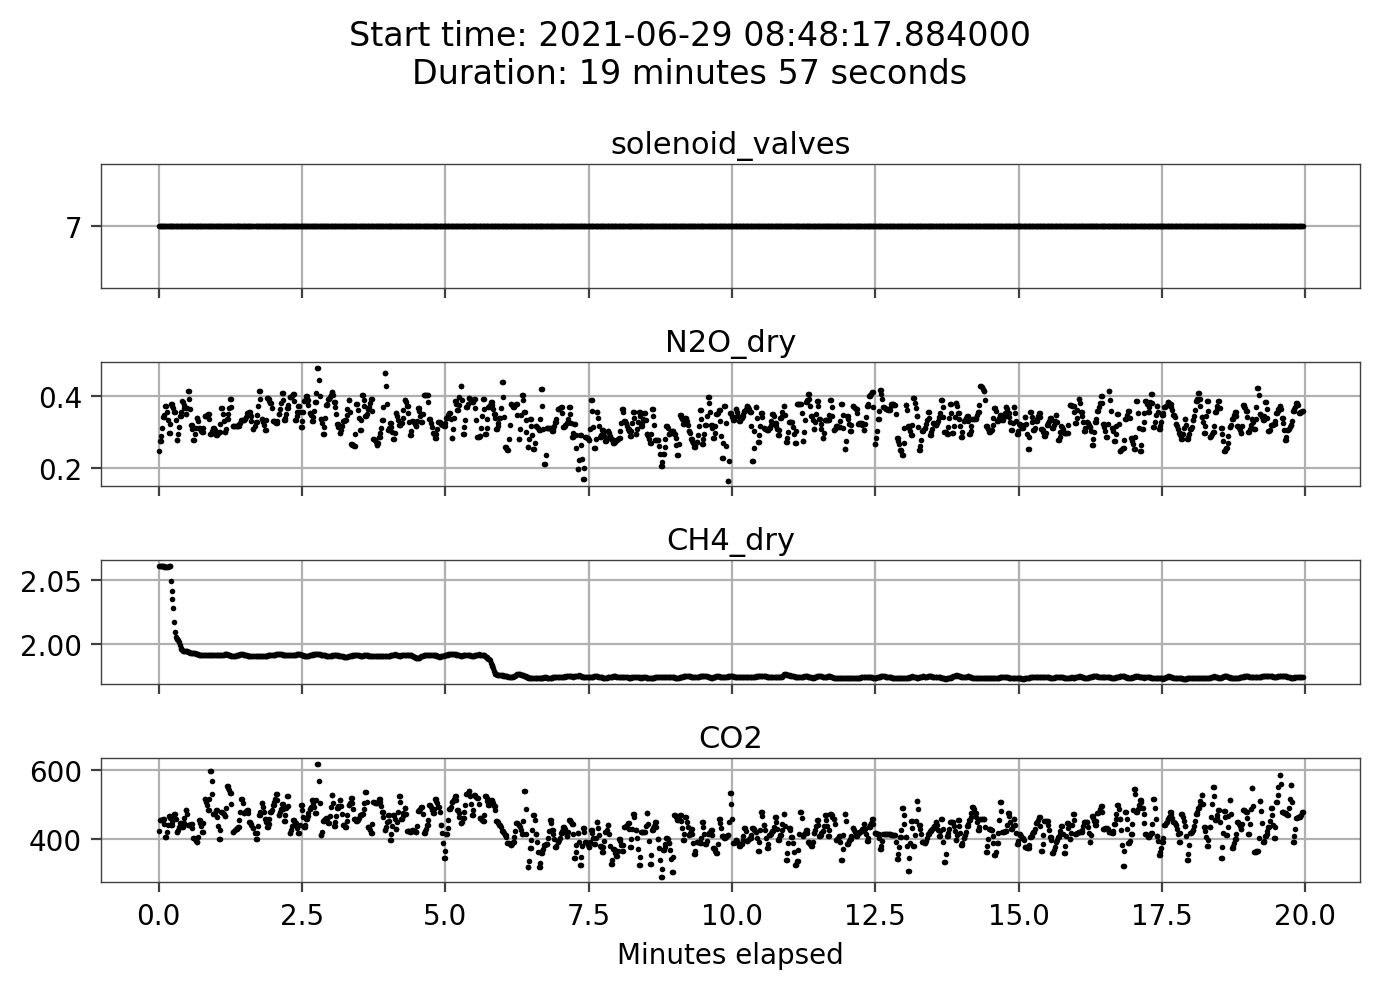

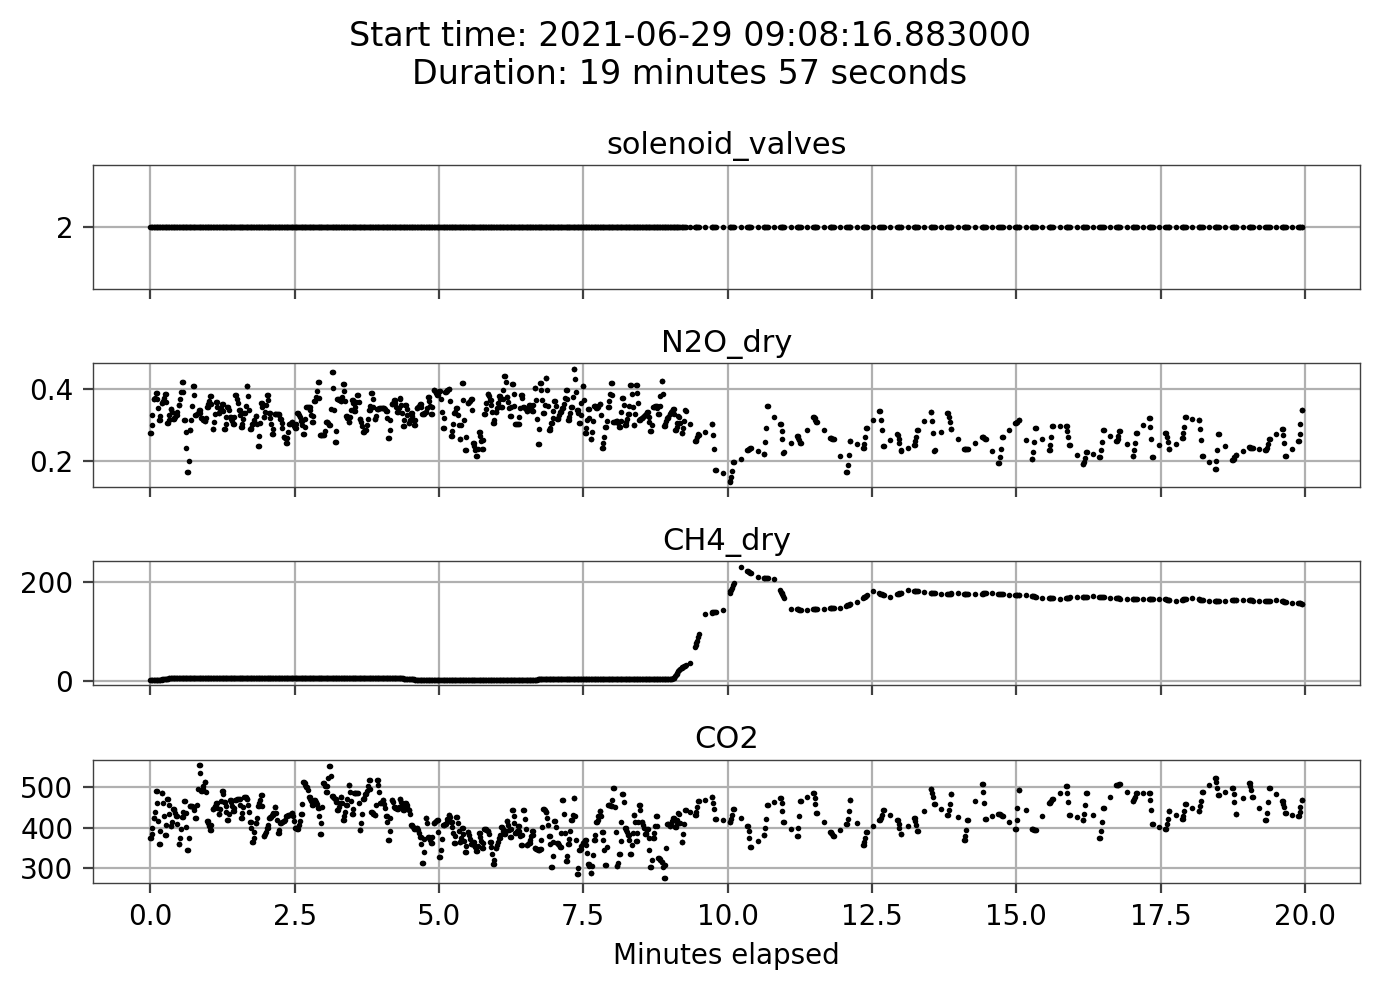

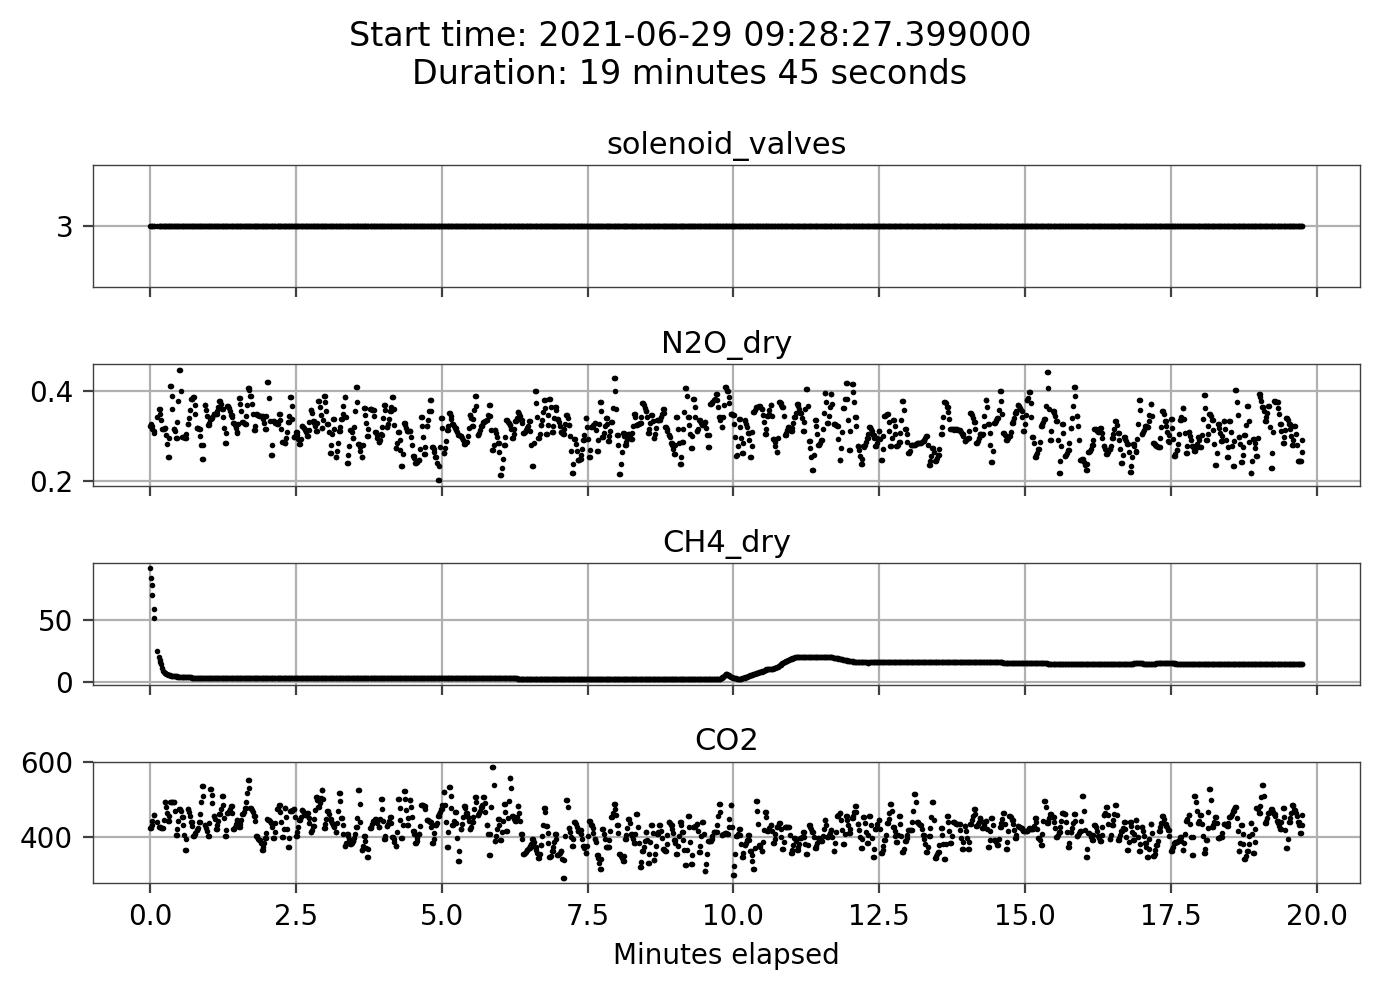

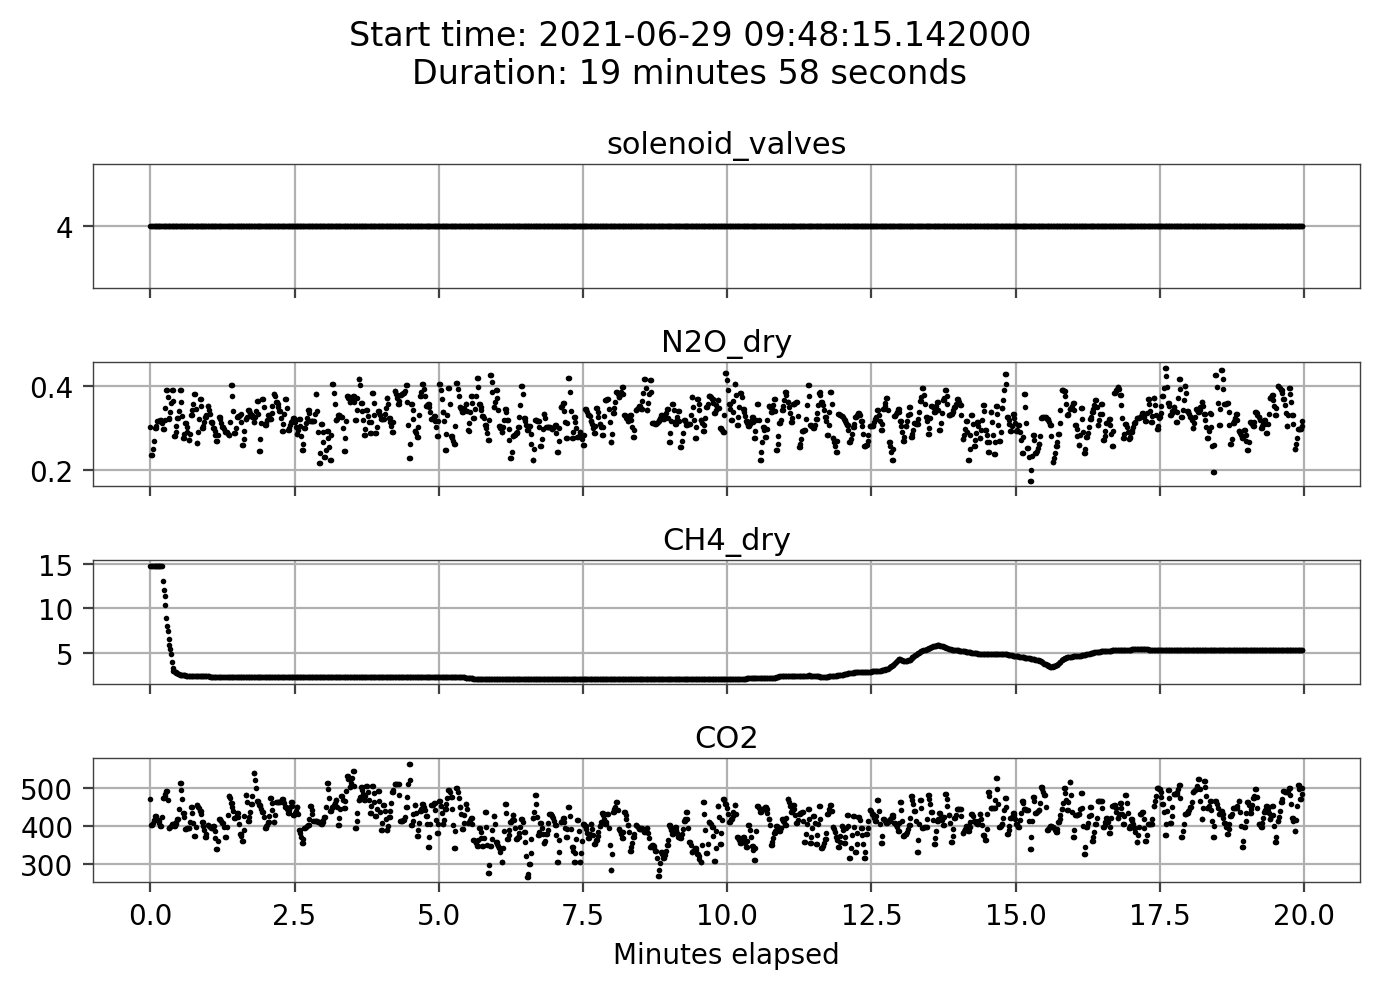

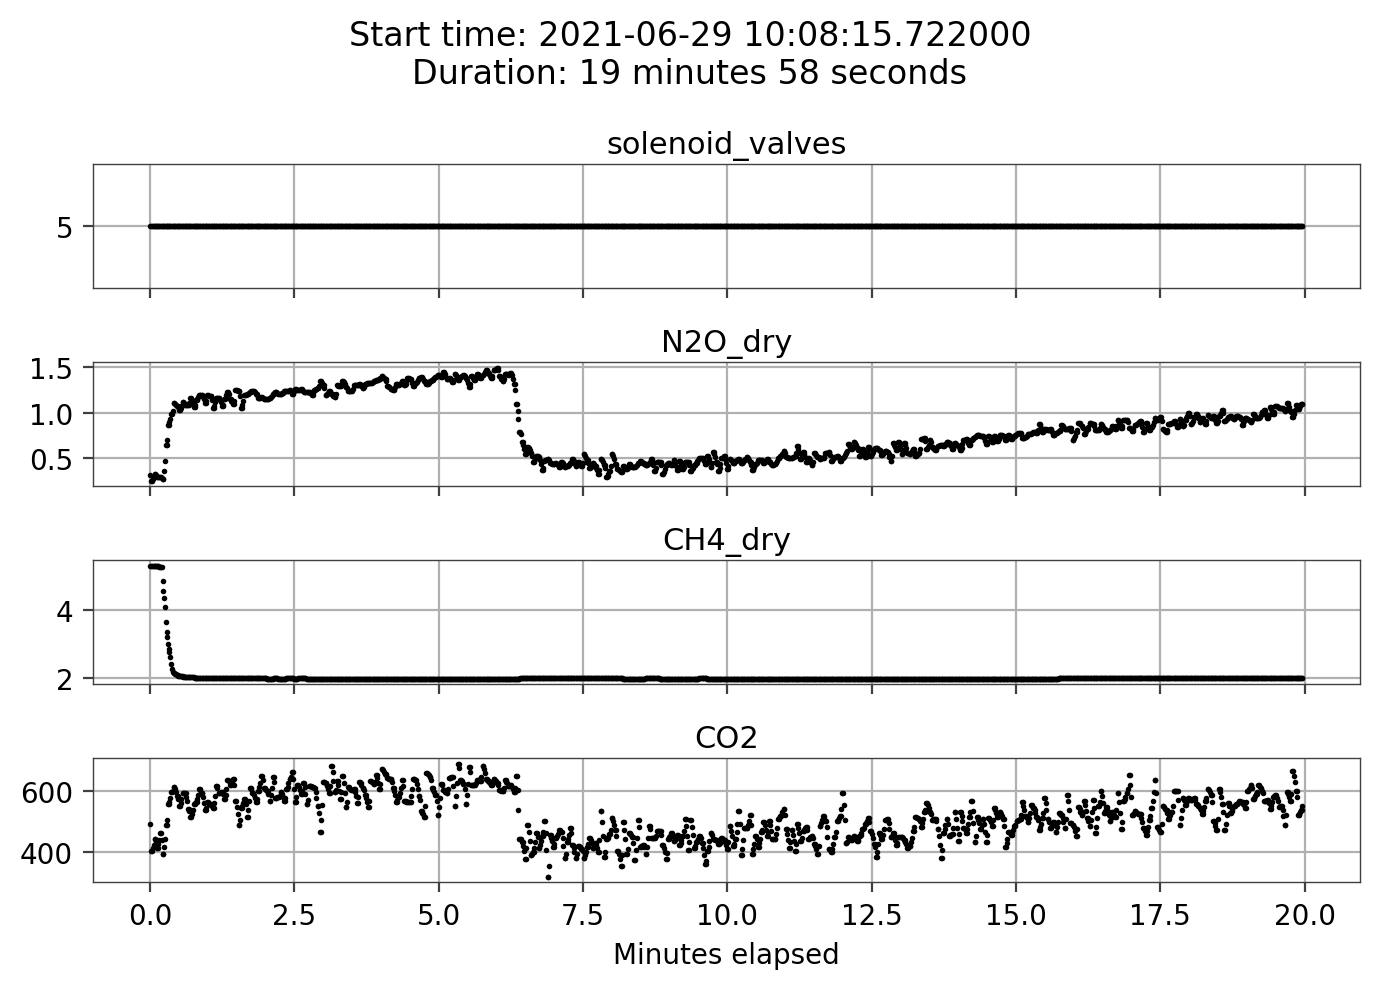

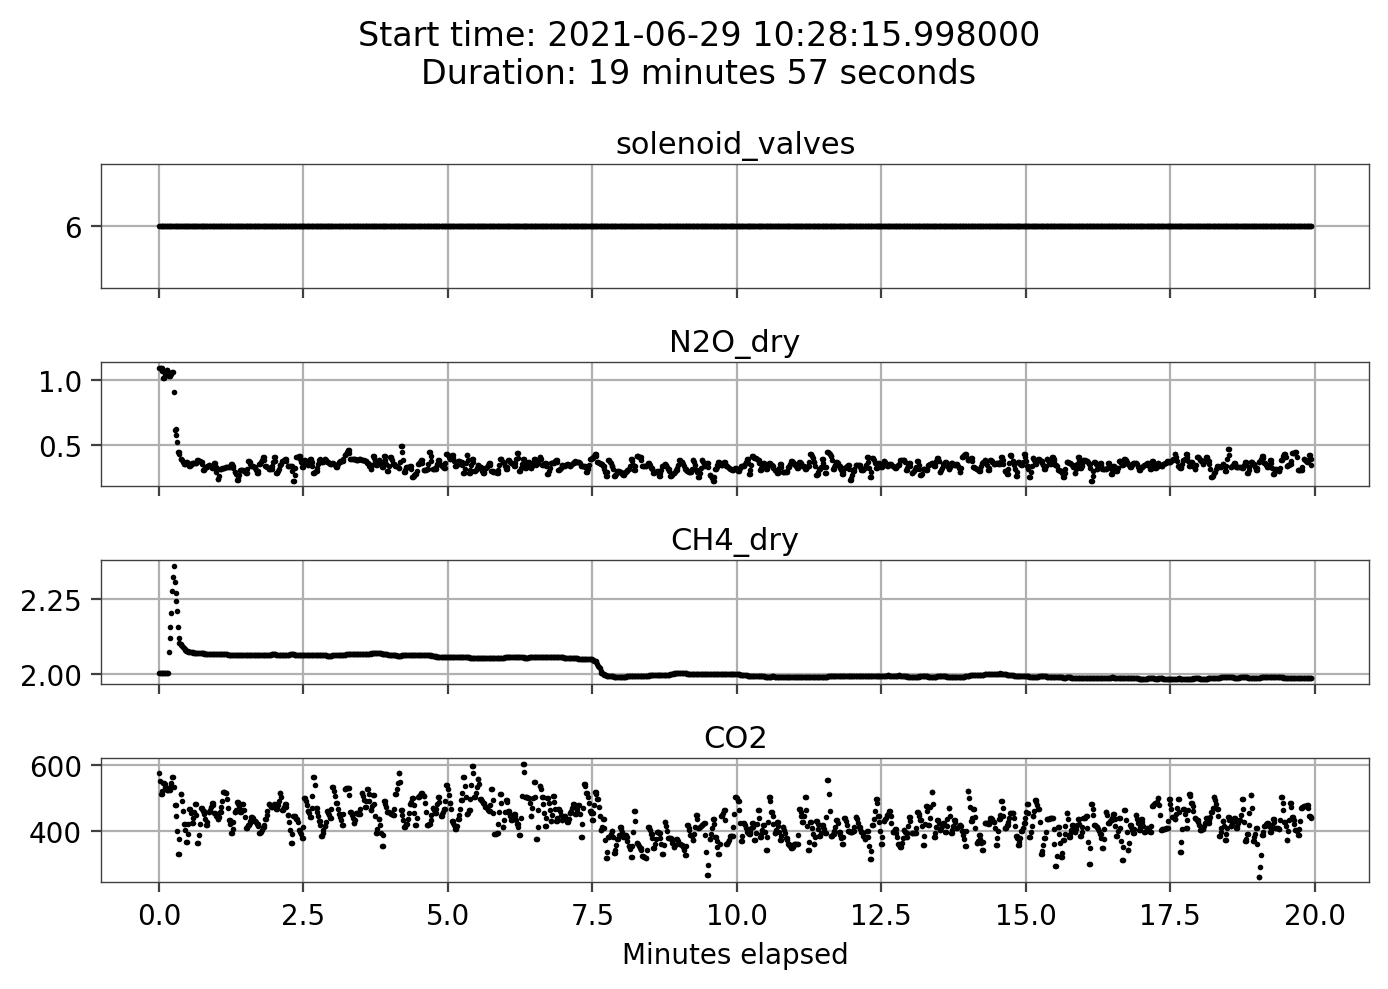

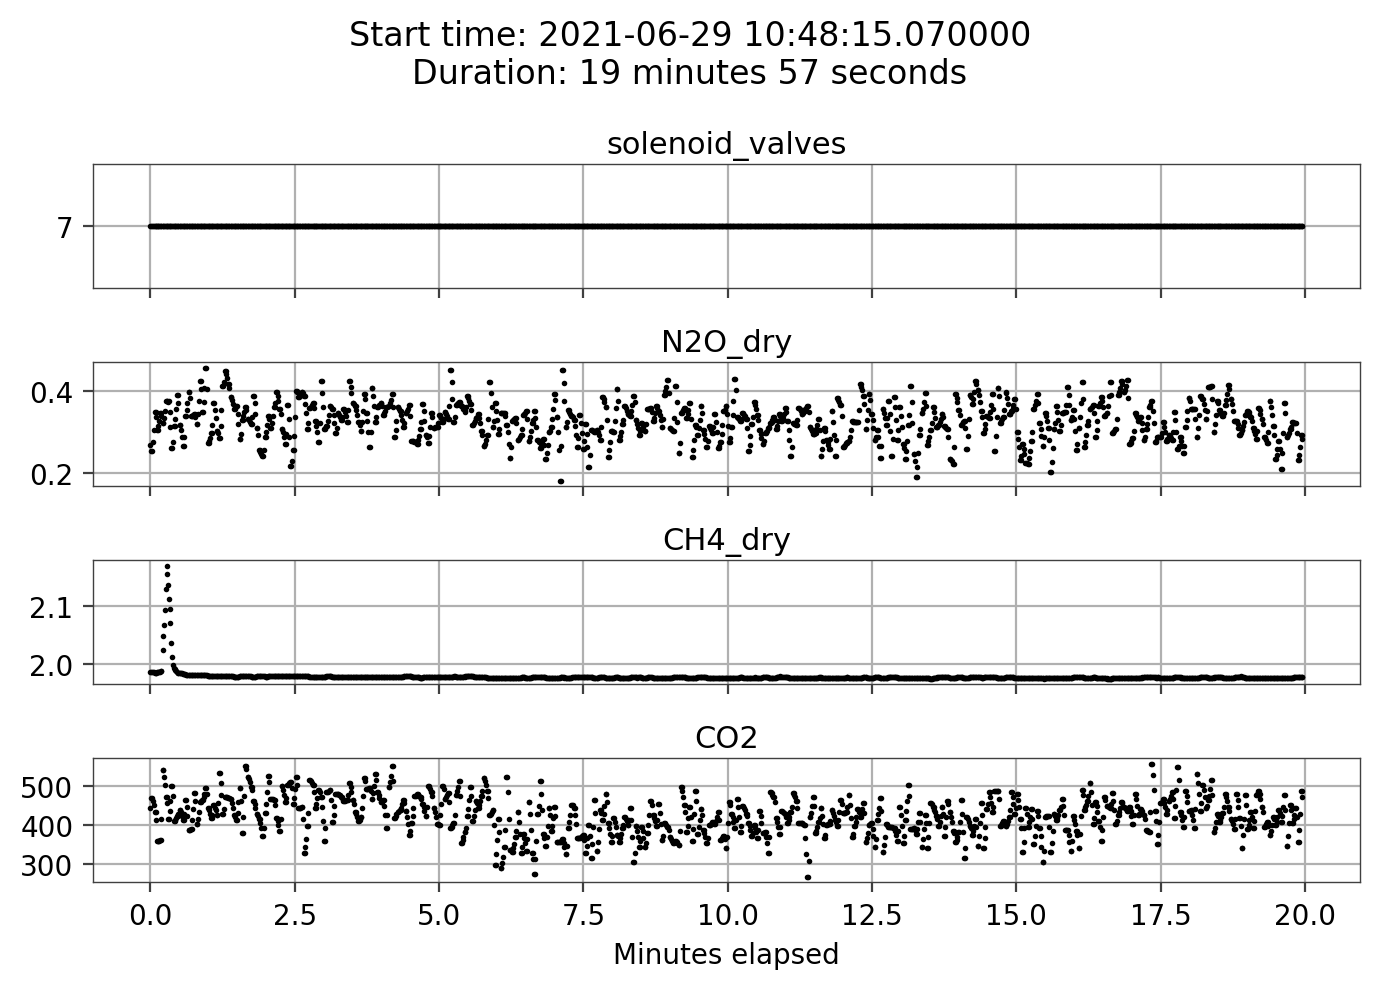

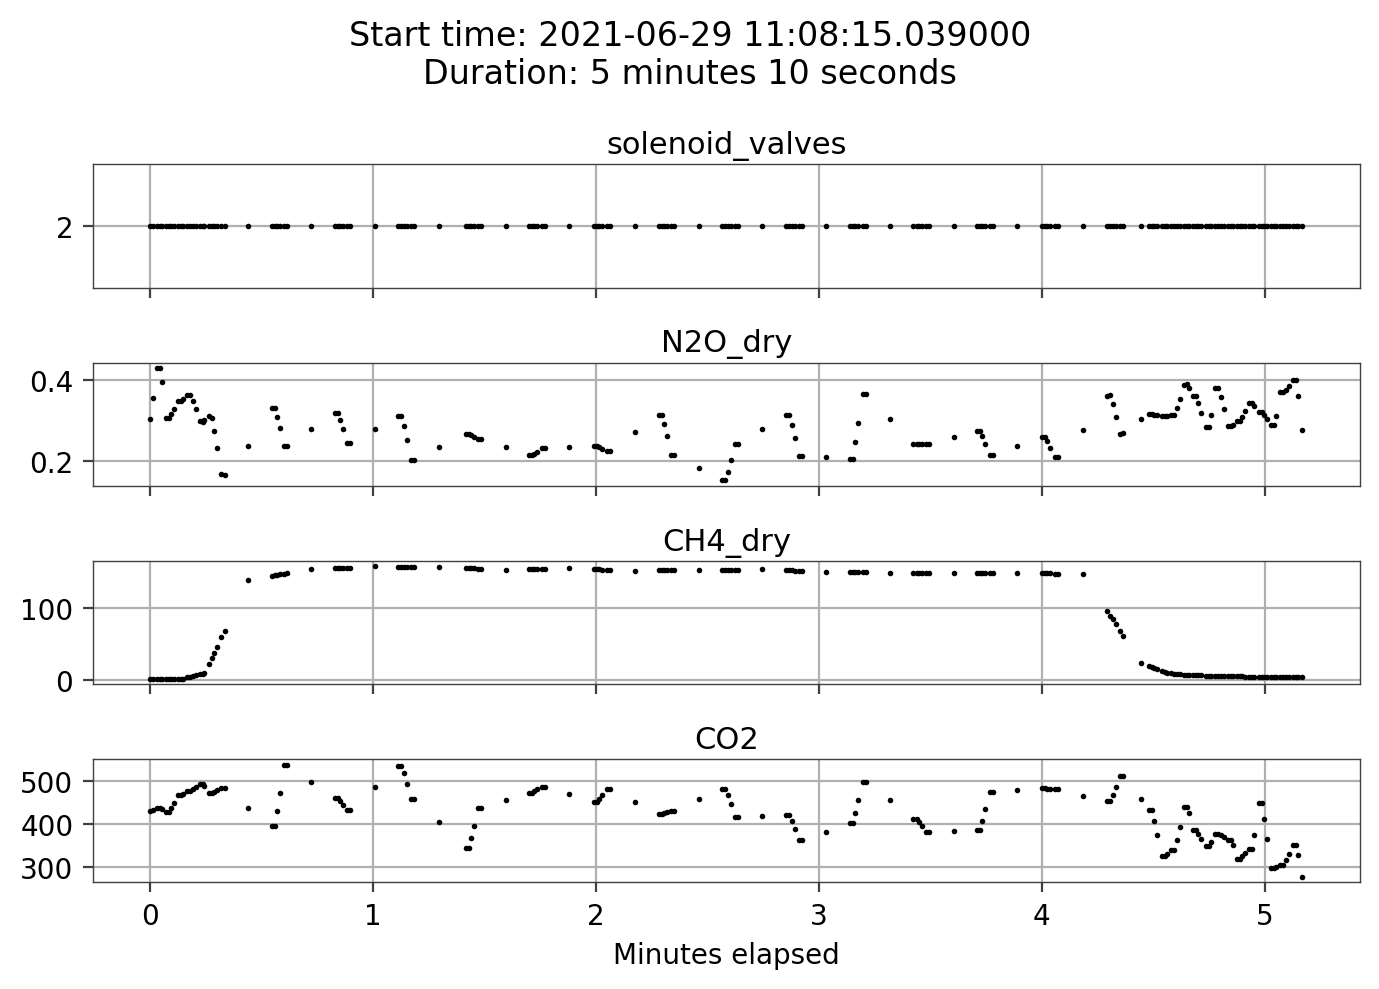

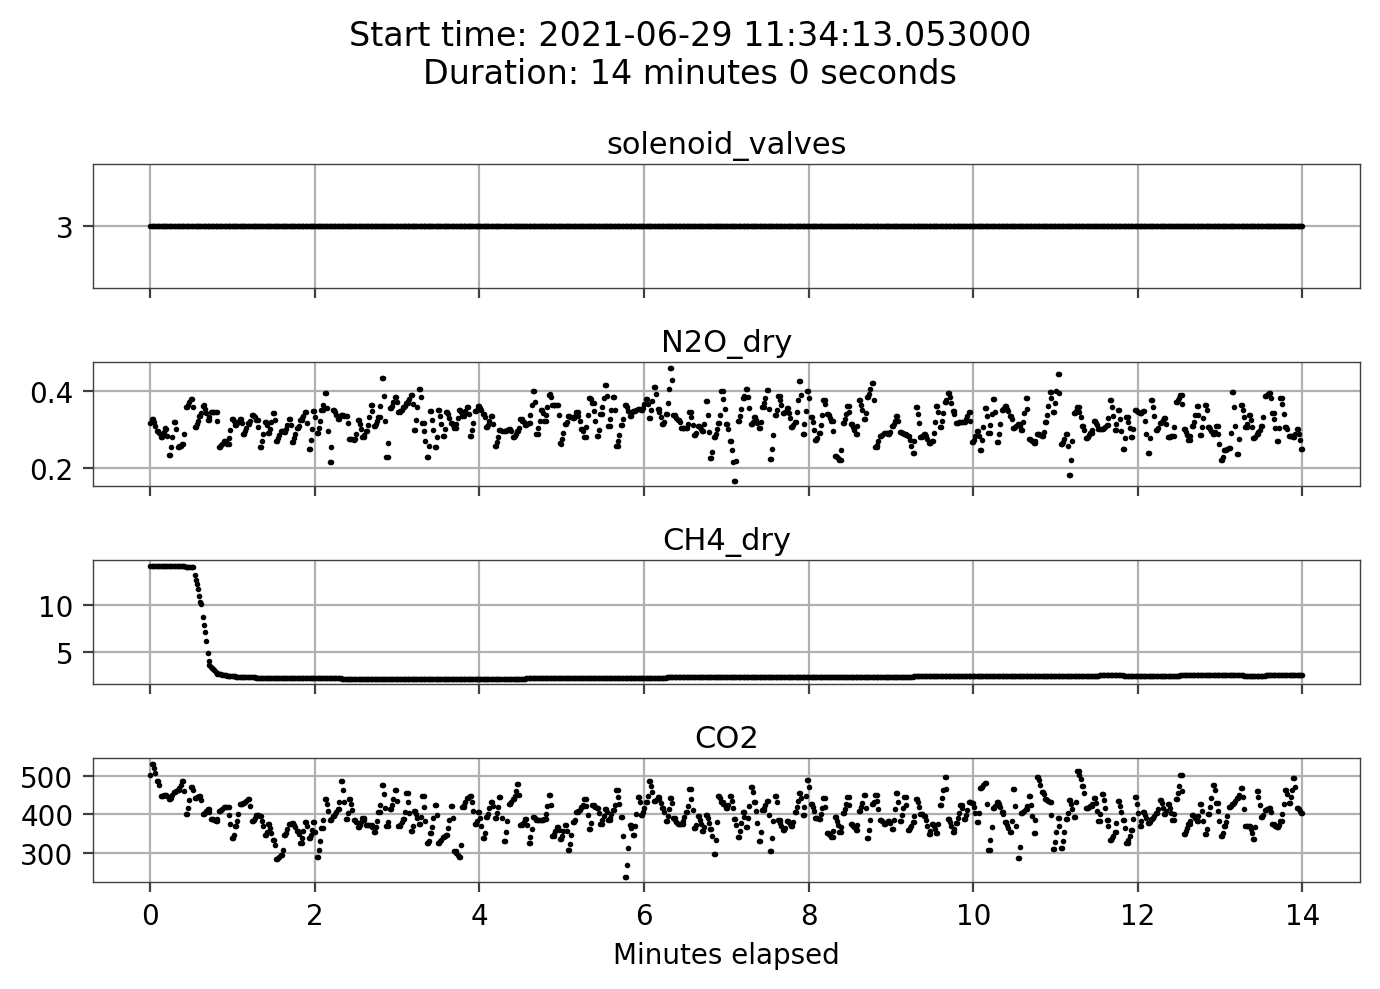

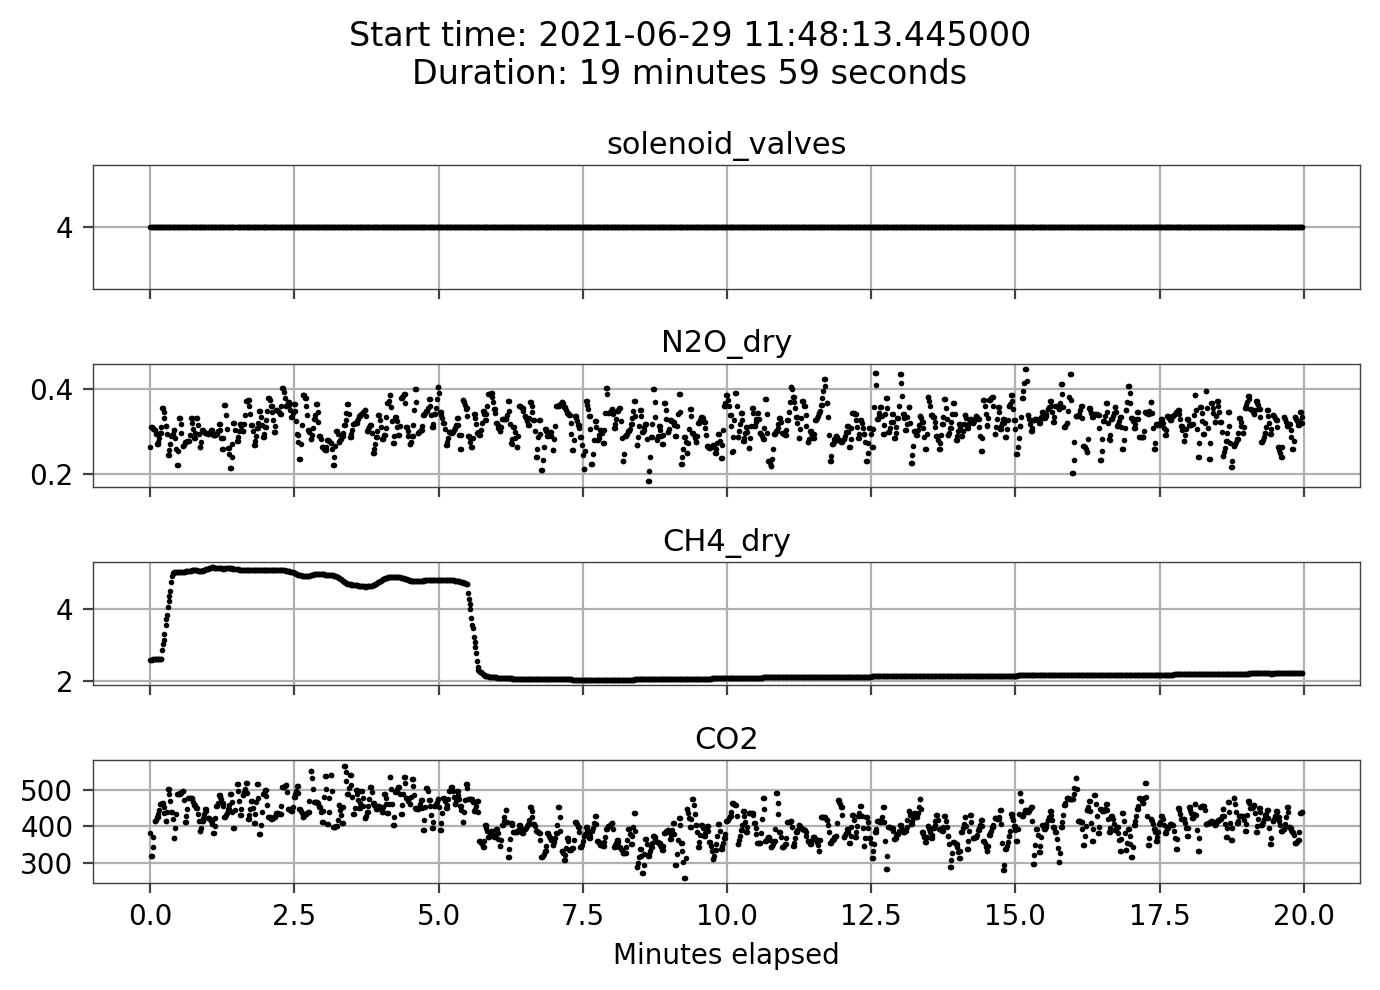

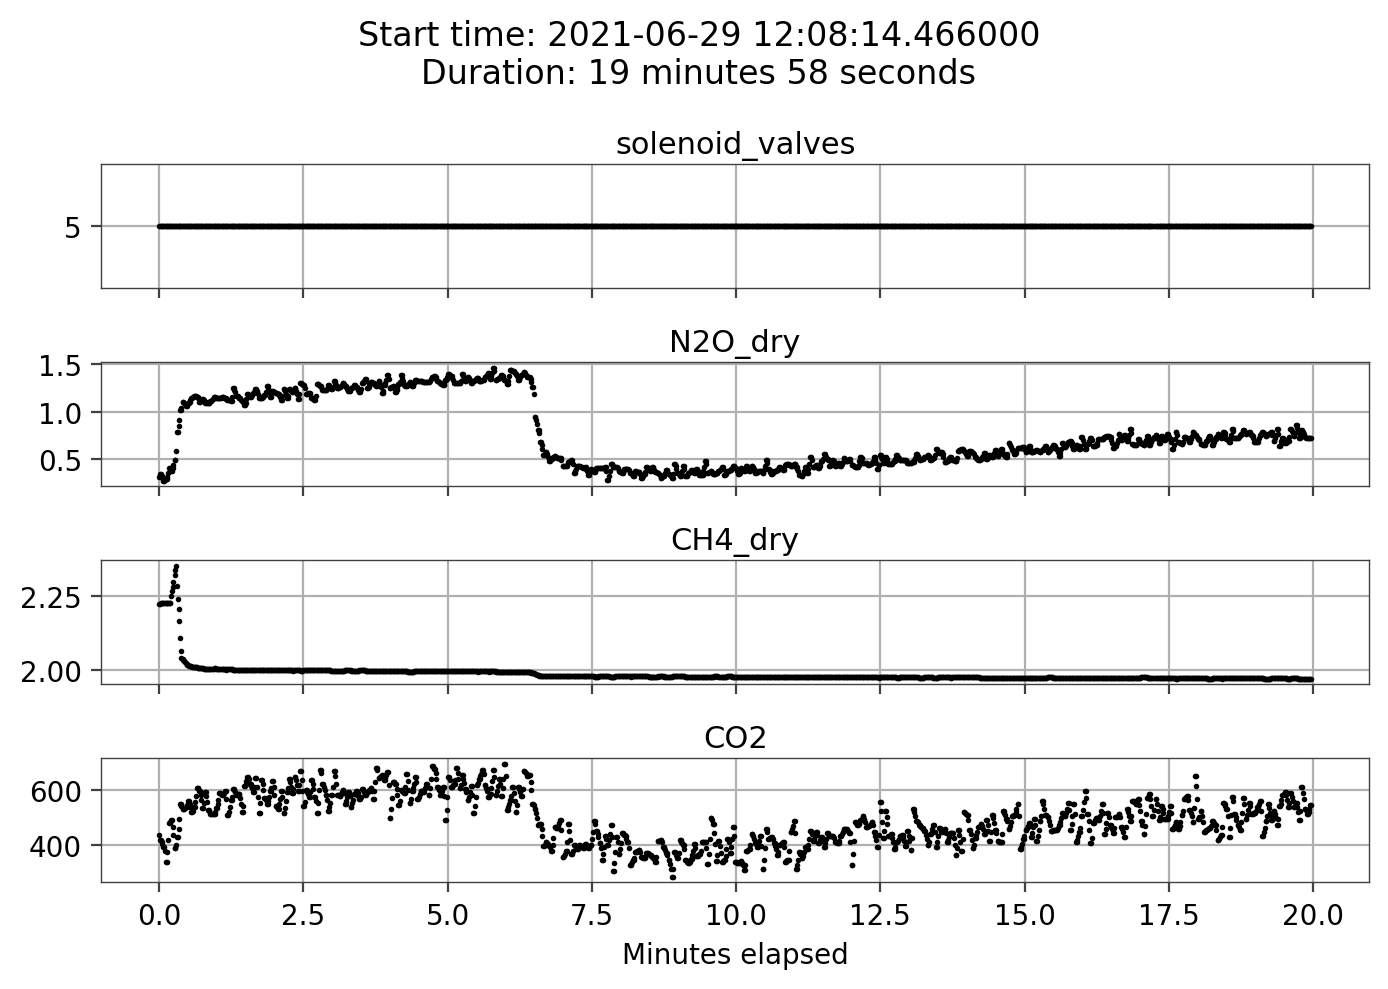

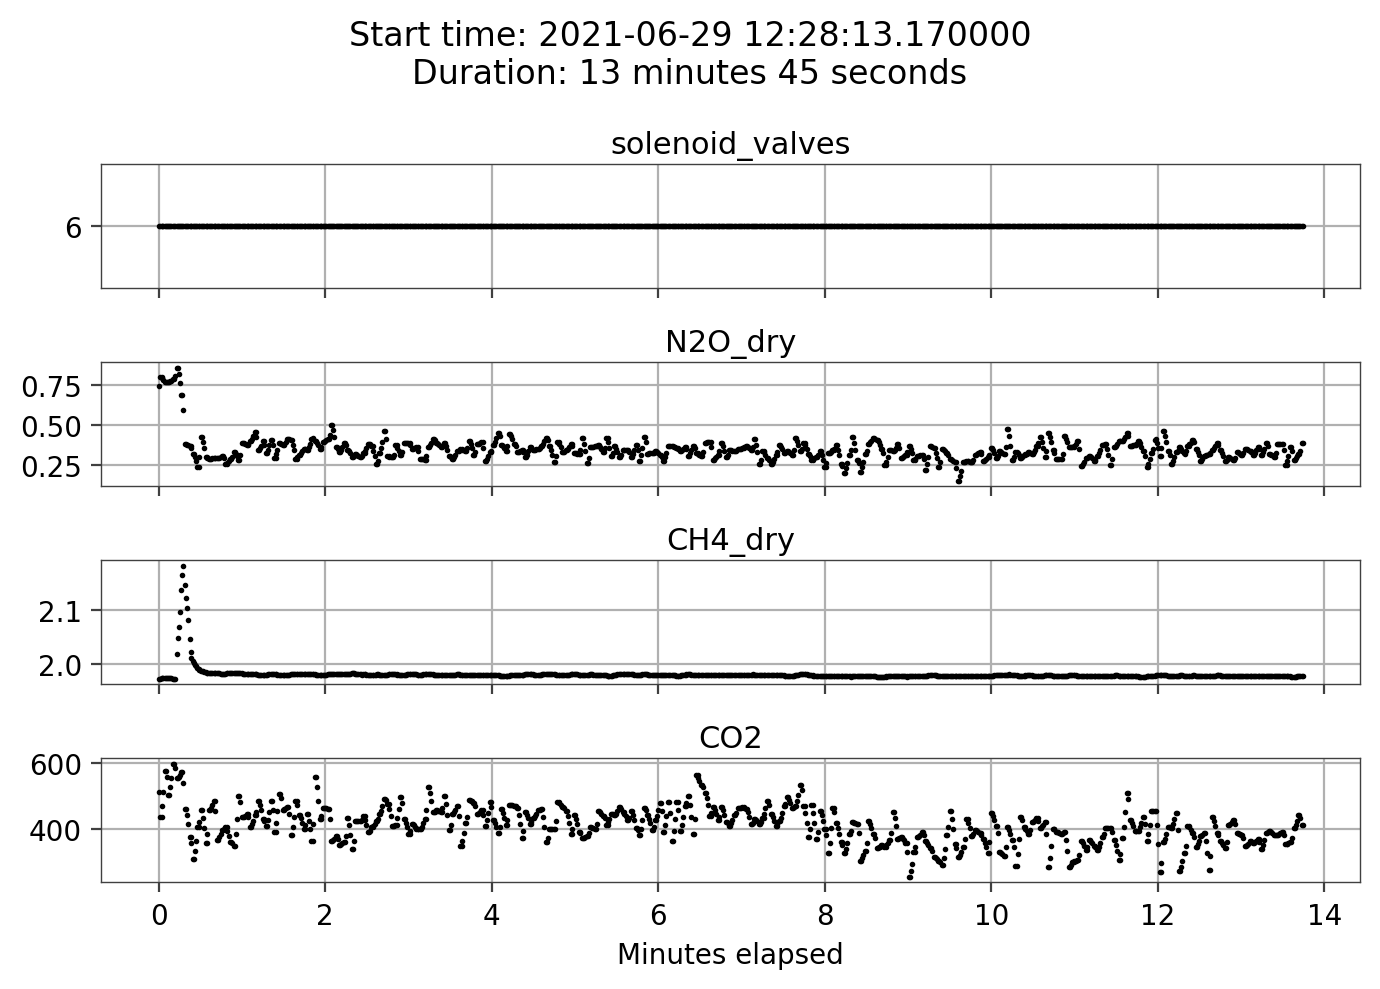

In [65]:
def split_measurements(data: pd.DataFrame) -> List[pd.DataFrame]:
    changed_valve = data["solenoid_valves"].diff().fillna(0) != 0
    measurement_number = changed_valve.cumsum()
    measurements = []
    for valve_number, measurement in data.groupby(measurement_number):
        measurements.append(measurement)
    return measurements


measurements = split_measurements(cleaned_all)

for m in measurements:
    plot_data(m);


## Looking closer at one measurement


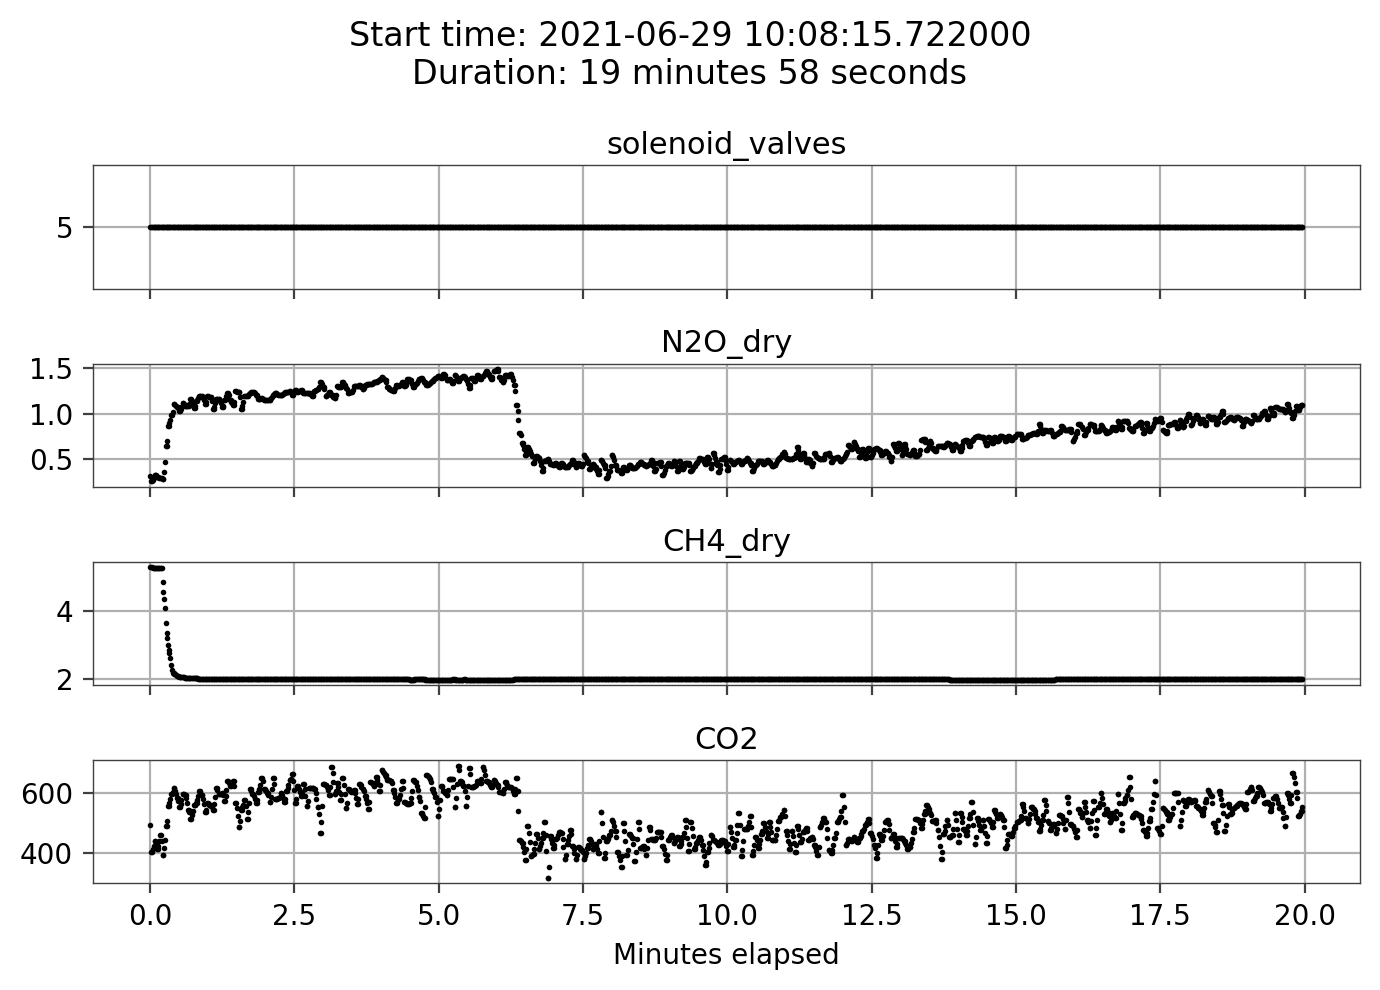

In [77]:
def find_measurement(measurement, start_time):
    for measurement in measurements:
        if measurement.index[0] == start_time:
            return measurement


measurement = find_measurement(measurements, pd.Timestamp("2021-06-29 10:08:15.722"))

fig = plot_data(measurement)
fig.savefig(fig_outdir / "example-measurement.png", dpi=200)


Consider the N2O concentration over time.

* First, there is a short period (about 30 seconds) where the concentration is rising from about 0.3 ppm to about 1 ppm. This is the last gas being analyzed from the previous measurement which was just concluded with chamber 4, and gradually being mixed with old gas from chamber 5. 
* Then there are about 6 minutes where the N2O concentration is above 1 ppm and rising. This is gas remaining in the tube from the last measurement on the same chamber (chamber 5); and the 6 minutes is the time it takes for the new gas to arrive from the chamber to the analyzer.
* After a little more than 6 minutes, the concentration quickly drops to about 0.4 ppm, which is roughly the atmospheric concentration at chamber 5 just when it closed for the current measurement.

The data after these initial 6.5 minutes is the data we will use to estimate the gas flux.

## Use the picarro package to analyze the N2O gas flux

We use the symbol `t0` for the time when the first gas from the current measurement arrives to the analyzer. In the `picarro` package, the 6.5 minutes discussed above are called `t0_delay`, because they define the delay between the chamber closure time (start of the data segment) and `t0`. So in this case we have
* `t0_delay` = 6.5 minutes
* `t0` = 2021-06-29 10:14:45.772 (= 2021-06-29 10:14:45.772 + 6.5 minutes)

In addition, we add an additional delay `t0_margin` to ensure that we do not accidentally use data from the previous measurement if our estimate of `t0` is a little wrong. (In practice, running the picarro program we will usually assume the same t0 for several chambers which in fact have slightly different delays. A good pragmatic solution is then to set an average value for t0 and then add a bit of extra margin to allow for some variation between the chambers.) Here, we set `t0_margin` to 3 minutes.

In [67]:
import picarro.fluxes

A = 0.25  # base area of chamber in m^2
V = 50 * 1e-3  # volume of chamber in m^3
h = V / A  # equivalent height of chamber in m

Q = 0.25 * 1e-3 / 60  # volumetric sample flow from chamber in m3/s (0.25 l/minute)
tau = datetime.timedelta(seconds=V / Q)  # time constant

t0_delay = datetime.timedelta(minutes=6.5)
t0_margin = datetime.timedelta(minutes=3)

estimation_params = picarro.fluxes.EstimationParams(
    t0_delay=t0_delay,
    t0_margin=t0_margin,
    tau=tau,
    h=h,
)
estimator = picarro.fluxes.ExponentialEstimator.fit(
    measurement["N2O_dry"],
    estimation_params,
)

vol_flux_estimate = estimator.estimate_vol_flux()

# this is the estimated volumetric N2O flux entering the chamber from the soil,
# expressed in 10^-6 m^3/m2/s = 10^-6 m/s (micrometers/second).
# The unit is in micrometers/second because the concentrations are given in ppm
# and all other units are base SI units.
vol_flux_estimate, estimator.linear_fit.slope


(0.0002066823981390098, 12.400943888340587)

In [68]:
# Note that the picarro package has calculated t0 and a few other points in time.
estimator.moments


Moments(data_start=Timestamp('2021-06-29 10:08:15.722000'), t0=Timestamp('2021-06-29 10:14:45.722000'), fit_start=Timestamp('2021-06-29 10:17:46.501000'), fit_end=Timestamp('2021-06-29 10:28:13.451000'), data_end=Timestamp('2021-06-29 10:28:13.451000'))

### Convert to molar flux

In [69]:
P = 101325  # pressure in Pa; assume 1 atmosphere
T = 293  # temperature in K; assume 20 degrees C
R = 8.314  # ideal gas constant

molar_flux = P * vol_flux_estimate / (R * T)  # because PV = nRT
molar_flux  # this is now in micromoles/m^2/s


0.008596911657476131

### Picarro can plot the estimation fit

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


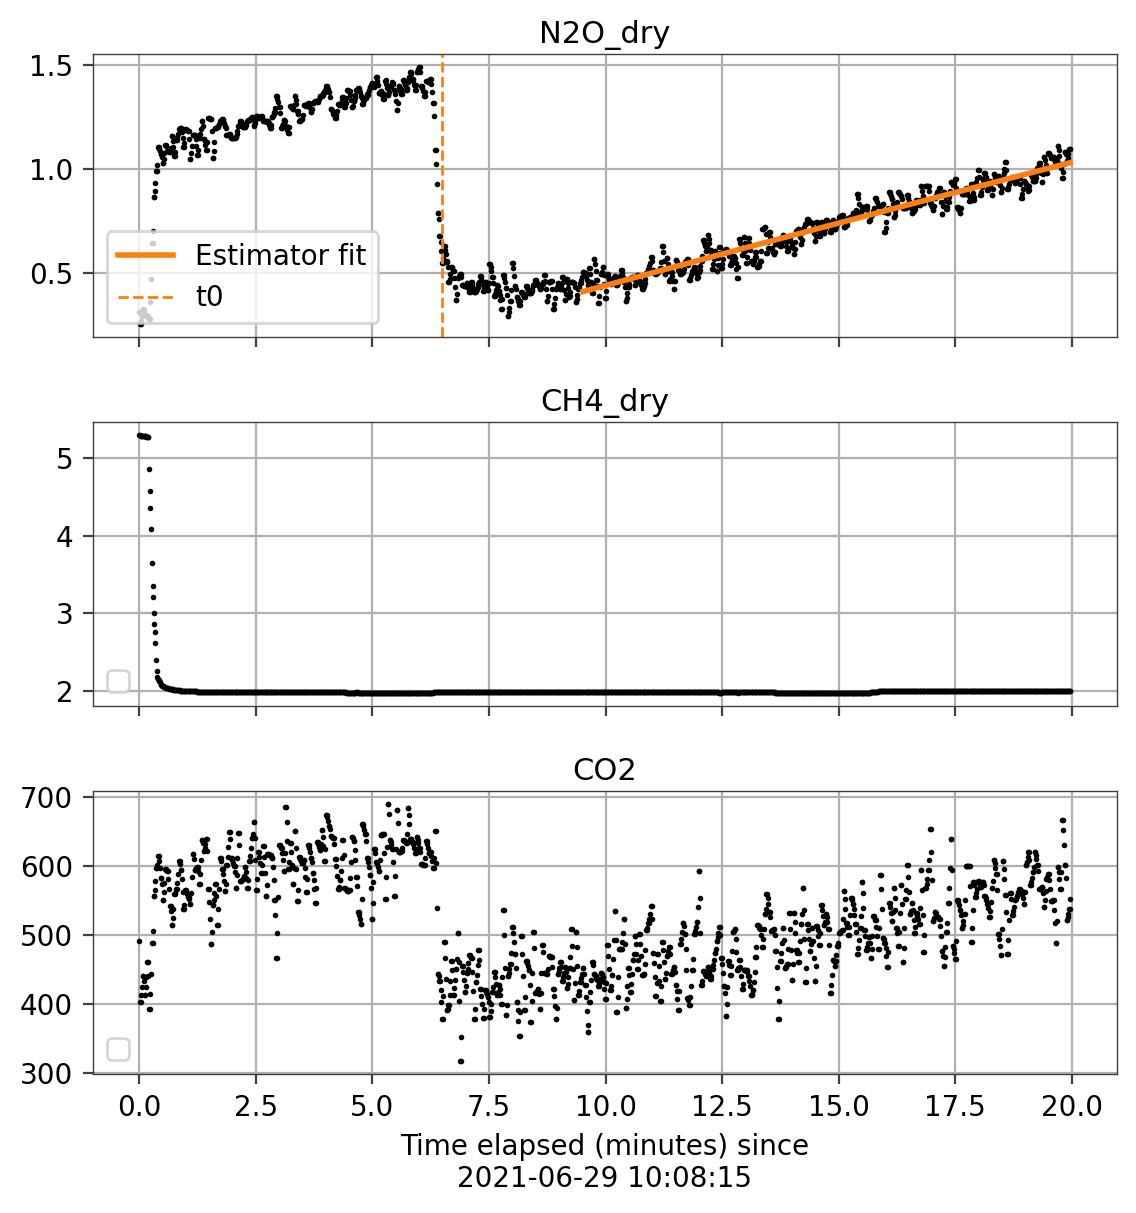

In [70]:
import picarro.plot

picarro.plot.plot_measurement(
    measurement.assign(valve_number=lambda d: d["solenoid_valves"]),
    ["N2O_dry", "CH4_dry", "CO2"],
    flux_estimates=[estimator],
);


## How the estimation works

The estimate of the volumetric flux is calculated by fitting an exponential curve to the concentration:

$$
c(t) = c(t_0) + F \frac{\tau}{h} \left( 1 - \exp(-(t-t_0)/\tau) \right)
$$

Here, $F$ is the volumetric flux we want to find, and $\tau$ and $h$ and $t_0$ are considered as known constants.

We can then use linear regression. Transform the time-dependent factor into
$$
x = \left( 1 - \exp(-(t-t_0)/\tau) \right)
$$
and then fit an estimator for the observed concentrations following the form
$$
\widehat{c} = b_0 + b_1 x.
$$
Here, $b_0$ and $b_1$ are the regression coefficients, and the interesting one is the slope $b_1$, because $b_1 = \widehat{F} \tau / h,$
where $\widehat{F}$ is our estimated volumetric flux. So we solve the equation and find the estimated flux
$$
\widehat{F} = b_1 \frac{h}{\tau}.
$$

In [71]:
# Checking that this is indeed what happened in the code:
b_1 = estimator.linear_fit.slope
F_hat = b_1 * h / tau.total_seconds()
dict(
    F_hat=F_hat,
    vol_flux_estimate=vol_flux_estimate,
)


{'F_hat': 0.0002066823981390098, 'vol_flux_estimate': 0.0002066823981390098}


## Sensitivity analysis for errors in parameter values

This can be tested by running the analysis with different values for the parameters and see how much it affects the flux estimate.

Let's try varying all the parameters by +/- 20%.

### Weak dependence on $\tau$ and `t0_delay` in practice

In practice, the sensitivity to errors in $\tau$ and $t_0$ is low. $\tau$ is a time constant which in our case is about 200 minutes, which can be compared to the measurement time of about 20 minutes. A 20% error in $\tau$ will therefore only make a very small difference for the flux estimates.

Basically for the same reason, the dependence on `t0_delay` is not very strong.

(The weak dependence on `t0_delay` is a result assuming that `t0_delay` + `t0_margin` is enough to reach into the "real" data after $t_0$. If we get these parameters so wrong that we start fitting the wrong data, of course results can be very wrong very quickly.)

### Linear unit dependence on $h$

The parameter $h$ only takes effect in the final expression for the flux estimate $\widehat{F} = b_1 \frac{h}{\tau}$ and therefore any change in $h$ translates linearly with the factor 1 into change in the flux estimate.

### These conclusions depend on the actual parameters in this case

Note that the quantitative conclusions here are dependent on the specific values we have here of $\tau$ and $h$ and so on. If you are working with a different system, it's a good idea to do your own analysis to make sure you know how sensitive the flux estimates are to the parameters. Just run the analysis with a range of different parameters to get a feeling for it.

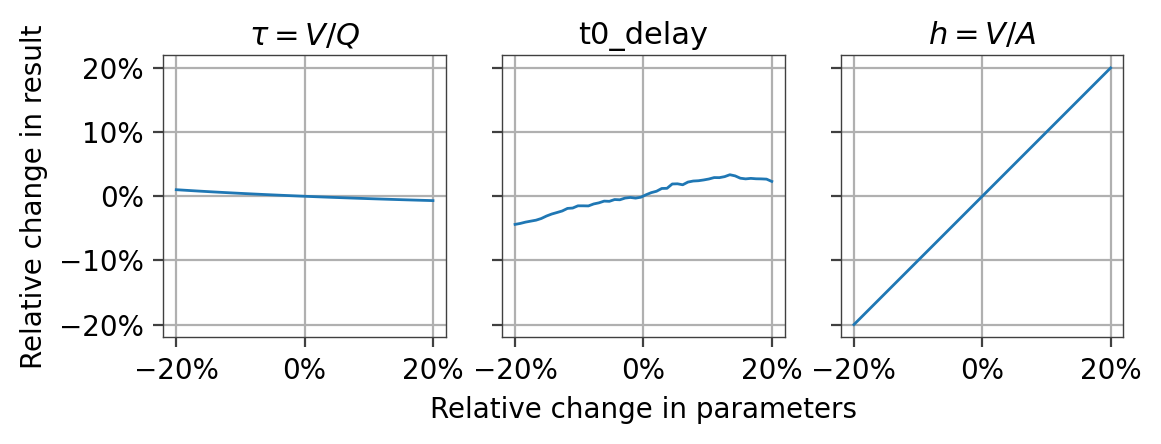

In [90]:
def estimate_alternative_flux(tau, t0_delay, h):
    estimation_params = picarro.fluxes.EstimationParams(
        t0_delay=t0_delay,
        t0_margin=t0_margin,
        tau=tau,
        h=h,
    )
    estimator = picarro.fluxes.ExponentialEstimator.fit(
        measurement["N2O_dry"],
        estimation_params,
    )

    vol_flux_estimate = estimator.estimate_vol_flux()

    return vol_flux_estimate


baseline_estimate = vol_flux_estimate
baseline_params = {
    "tau": tau,
    "t0_delay": t0_delay,
    "h": h,
}
param_labels = {
    "tau": r"$\tau = V/Q$",
    "t0_delay": r"t0_delay",
    "h": r"$h = V/A$",
}
relative_param_values = np.linspace(0.8, 1.2)

fig, axs = plt.subplots(ncols=3, sharey=True)
for param_name, ax in zip(["tau", "t0_delay", "h"], axs):
    param_values = [baseline_params[param_name] * v for v in relative_param_values]
    flux_estimates = np.array(
        [
            estimate_alternative_flux(
                **{**baseline_params, **{param_name: param_value}}
            )
            for param_value in param_values
        ]
    )
    relative_flux_change = flux_estimates / baseline_estimate - 1
    relative_param_change = relative_param_values - 1
    ax.plot(pd.Series(index=relative_param_change, data=relative_flux_change))
    ax.set_title(param_labels[param_name])
    ax.set_aspect(1)
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, decimals=0))
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, decimals=0))


axs[0].set_ylabel("Relative change in result")
axs[1].set_xlabel("Relative change in parameters")

fig.savefig(fig_outdir / "example-sensitivity.png", dpi=200, bbox_inches="tight")
